# Artificial Neural Networks _from the ground up_

Deep learning allows computational models that are composed of
multiple processing **layers** to learn representations of data
with multiple levels of abstraction.

These methods have dramatically improved the state-of-the-art in speech recognition,
visual object recognition, object detection and many other domains
such as drug discovery and genomics.

**Deep learning** is one of the leading tools in data analysis these days.
This led to the development to many different framework specific
for deep learning such as **PyTorch** or **Keras**.

## This Section will cover:

* Getting a conceptual understanding of multi-layer neural networks;
* Training neural networks on artificially generated data;
* Implementing the backpropagation algorithm;
* Debugging neural network implementations.

# Building Blocks: Perceptron (or Neural Network Neuron)

In machine learning and cognitive science, an artificial neural network (ANN)
is a network inspired by biological neural networks
which are used to estimate or approximate functions that can depend on a
large number of inputs that are generally unknown.

An ANN is built from nodes (neurons) stacked in layers between the feature
vector and the target vector.

A node in a neural network is built from Weights and Activation function.

An early version of ANN built from one node was called the **Perceptron**

<img src="../imgs/Perceptron.png" width="45%">

---

The Perceptron is an algorithm for supervised learning of binary classifiers.
functions that can decide whether an input (represented by a vector of numbers)
belongs to one class or another.

Much like logistic regression, the weights in a neural net are being multiplied
by the input vector summed up and fed into the activation function's input.

A Perceptron Network can be designed to have *multiple layers*,
leading to the **Multi-Layer Perceptron** (aka `MLP`)

<img src="../imgs/MLP.png" width="45%">

## Building Neural Nets from scratch 


### Idea:

- We will build the neural networks from first principles.
- We will create a very simple model and understand how it works.
- We will also be implementing backpropagation algorithm. 

**Please note that this code is not optimized and not to be used in production**. 

Libraries like `torch` have highly optimized code to do so.

---

## Interlude: Vectorization


In [6]:
import numpy as np

In [8]:
def forloop(x, w):
    z = 0.
    for i in range(len(x)):
        z += x[i] * w[i]
    return z


def listcomprehension(x, w):
    return sum(x_i*w_i for x_i, w_i in zip(x, w))


def vectorized(x, w):
    return x_vec.dot(w_vec)


x, w = np.random.rand(100000), np.random.rand(100000)
x_vec, w_vec = np.array(x), np.array(w)

In [7]:
a = np.ones(5)*2
b = np.ones(5)*5

np.sum(a*b)

50.0

In [9]:
%timeit -r 100 -n 10 forloop(x, w)

42.1 ms ± 2.01 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [10]:
%timeit -r 100 -n 10 listcomprehension(x, w)

35.7 ms ± 1.25 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [48]:
%timeit -r 100 -n 10 vectorized(x_vec, w_vec)

The slowest run took 87.73 times longer than the fastest. This could mean that an intermediate result is being cached.
60.7 µs ± 192 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [50]:
%timeit -r 100 -n 10 np.sum(x_vec*w_vec)

The slowest run took 5.43 times longer than the fastest. This could mean that an intermediate result is being cached.
111 µs ± 56.7 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [55]:
%timeit -r 100 -n 10 x_vec.dot(w_vec)

The slowest run took 29.45 times longer than the fastest. This could mean that an intermediate result is being cached.
46.5 µs ± 94.5 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


### Perceptron and Adaline Models


If you want a sneak peek of alternate (production ready) implementation of _Perceptron_ for instance try:
```python
from sklearn.linear_model import Perceptron
```

## Defining the Perceptron model

<img src="../imgs/Perceptron.png" width="35%">

#### Binary Classification

While we used the **activation** $\phi(z)$ to compute the gradient update, we may use a **threshold function** _(Heaviside step function)_ to squash the continuous-valued output into binary class labels for prediction:

$$
\hat{y} = 
\begin{cases}
    1 & \text{if } \phi(z) \geq 0 \\
    0 & \text{otherwise}
\end{cases}
$$

In [13]:
class Perceptron:
    """Perceptron Numpy Implementation"""

    def __init__(self, num_features: int, epochs: int = 10):
        self.num_features = num_features
        self.weights = np.zeros((num_features, 1), dtype=np.float)
        self.bias = np.zeros(1, dtype=np.float)
        self._n_epochs = epochs

    def forward(self, x):
        linear = np.dot(x, self.weights) + self.bias
        predictions = np.where(linear > 0., 1, 0)
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def fit(self, x, y):
        for e in range(self._n_epochs):
            for i in range(y.shape[0]):
                errors = self.backward(x[i].reshape(1, self.num_features),
                                       y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors

    def predict(self, x):
        return self.forward(x).reshape(-1)

    @staticmethod
    def evaluate(y, y_pred):
        return np.sum(y_pred == y) / y.shape[0]

#### Preparing a toy dataset

In [14]:
from ann import load_data

X, y = load_data()
print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


#### Train/Test Split

In [15]:
# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

### Training the Perceptron

#### Plotting Training Data

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

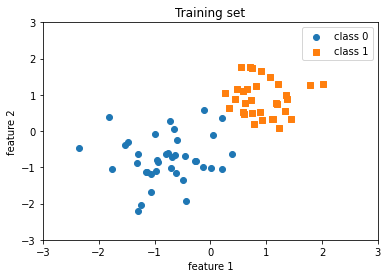

In [17]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

In [18]:
ppn = Perceptron(num_features=2, epochs=5)

ppn.fit(X_train, y_train)

print('Model parameters:\n\n')
print('  Weights: %s\n' % ppn.weights)
print('  Bias: %s\n' % ppn.bias)

Model parameters:


  Weights: [[1.27340847]
 [1.34642288]]

  Bias: [-1.]



### Evaluating the model

In [19]:
y_pred = ppn.predict(X_test)
print('Test set accuracy: %.2f%%' % (ppn.evaluate(y_test, y_pred)*100))

Test set accuracy: 93.33%


#### Plot decision Boundary

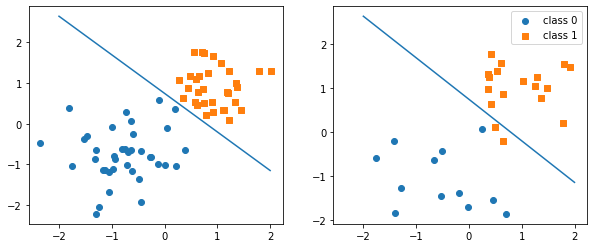

In [20]:
from ann import plot_decision_boundary

_, _ = plot_decision_boundary(ppn, X=(X_train, X_test), y=(y_train, y_test))
plt.show()

### Visualising the Learinng Process

In [70]:
all_weights = []
all_biases = []

ppn = Perceptron(num_features=2, epochs=1)

acc = 0

for i in range(X_train.shape[0]): 
    all_weights.append(ppn.weights.copy())
    all_biases.append(ppn.bias.copy())
    ppn.fit(X_train[i].reshape(1, -1), y_train[i].reshape(-1))

    y_pred = ppn.predict(X_test)
    acc = ppn.evaluate(y_test, y_pred)

#### Plotting the boundary for each training step

In [79]:
# !pip install imageio
import imageio

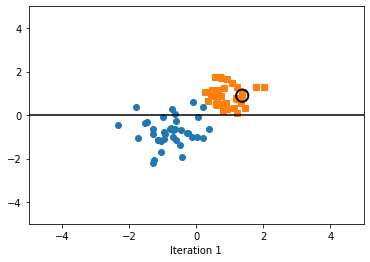

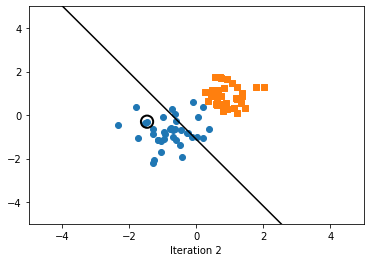

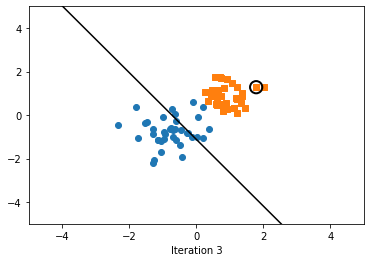

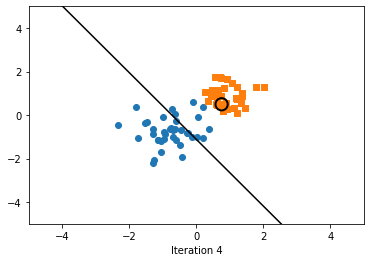

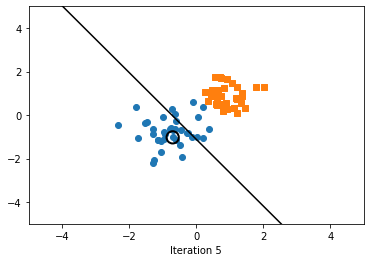

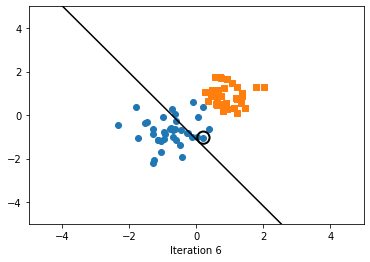

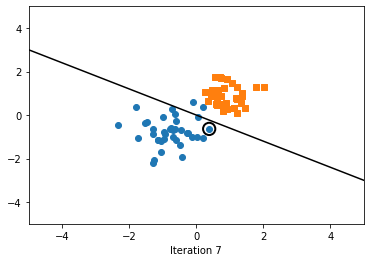

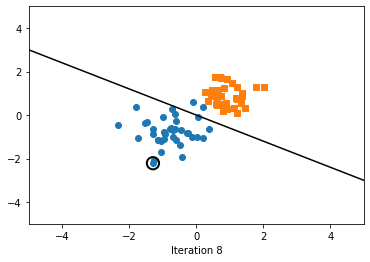

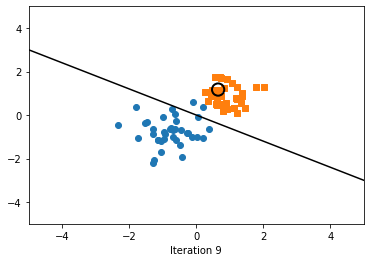

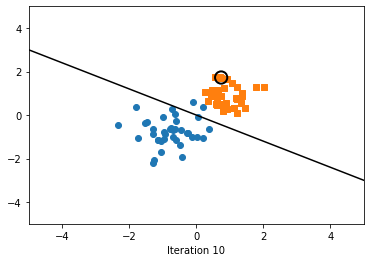

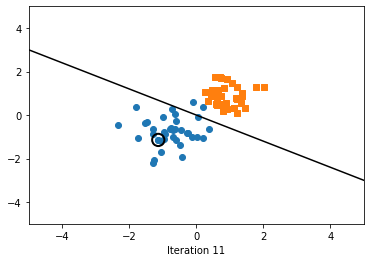

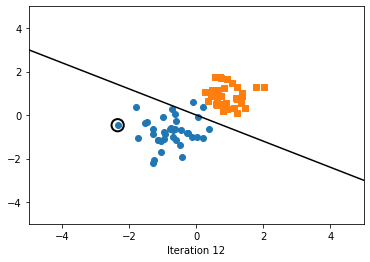

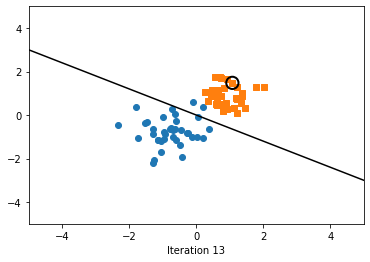

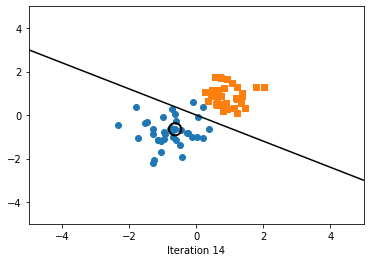

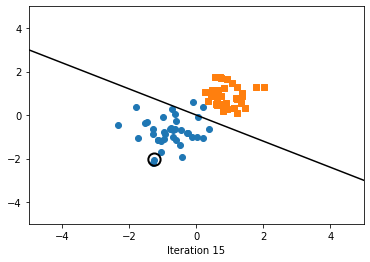

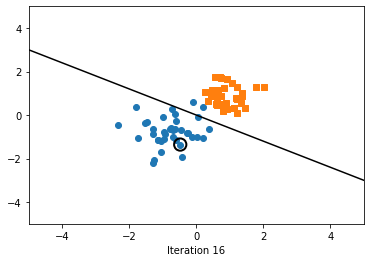

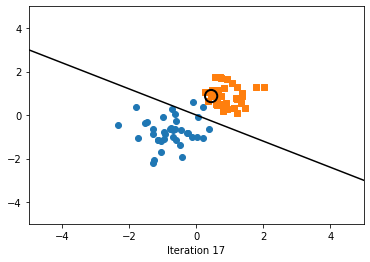

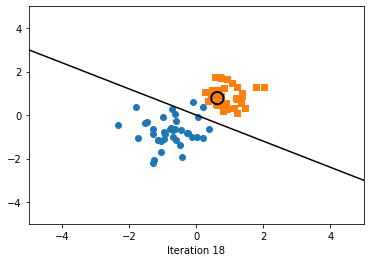

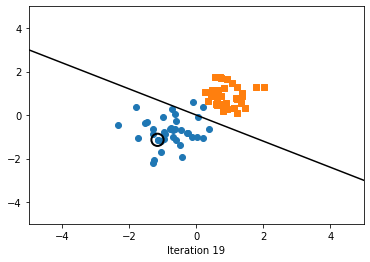

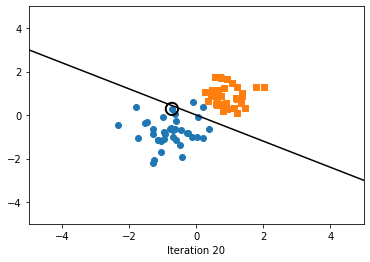

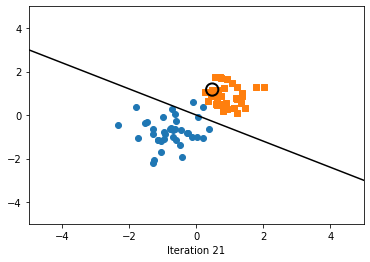

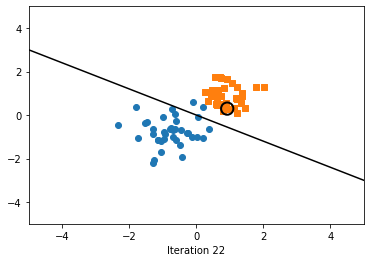

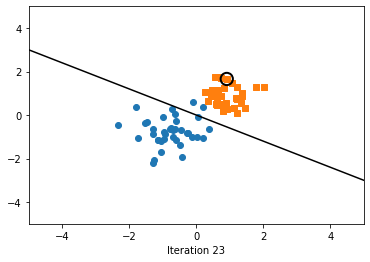

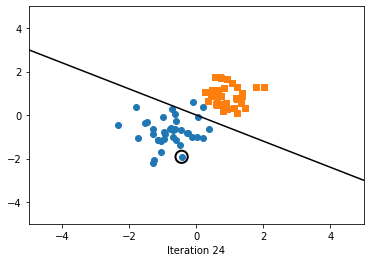

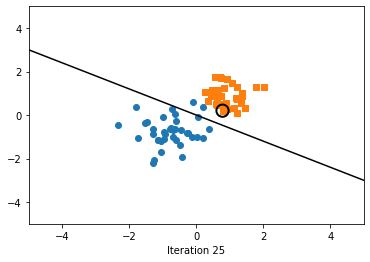

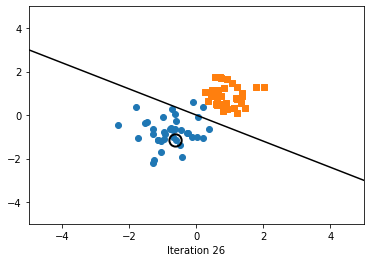

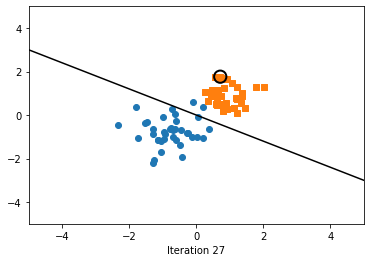

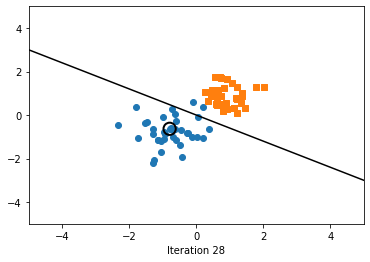

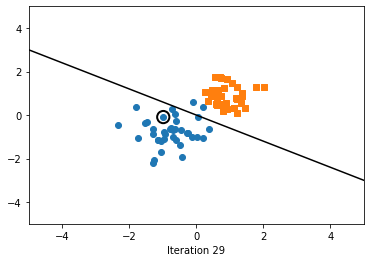

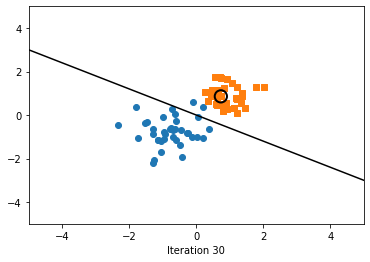

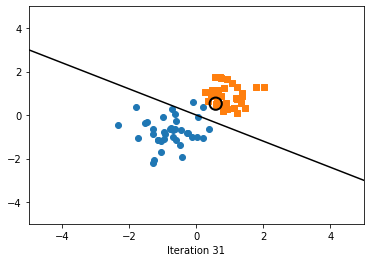

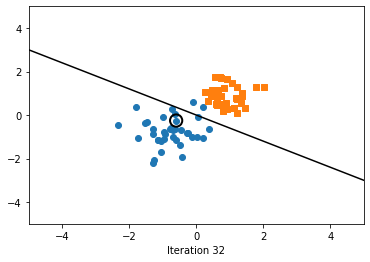

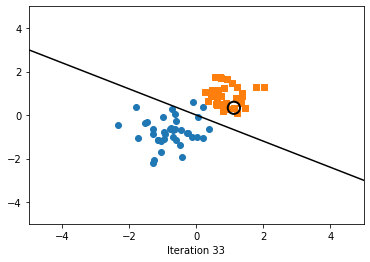

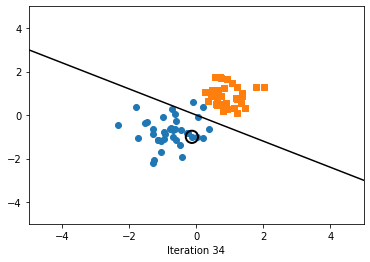

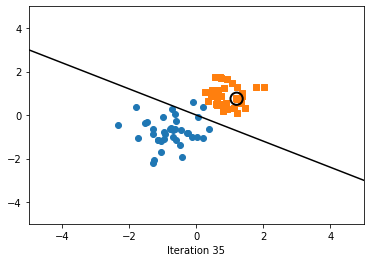

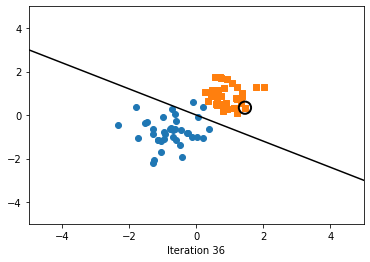

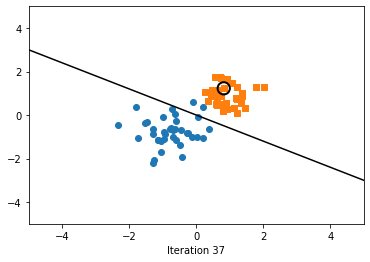

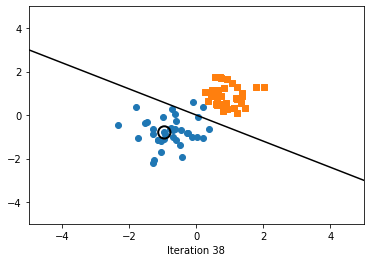

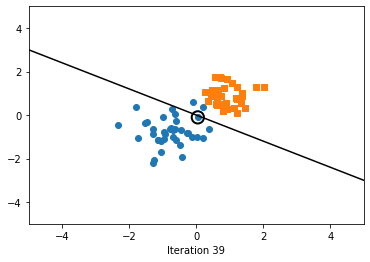

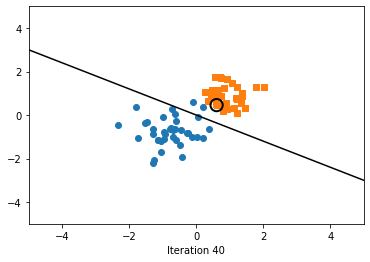

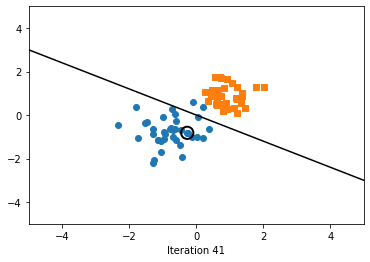

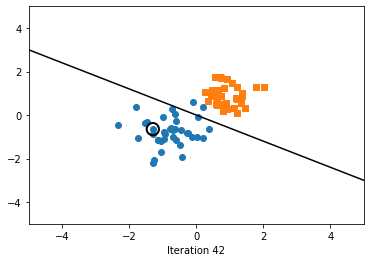

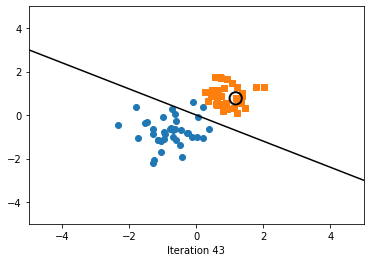

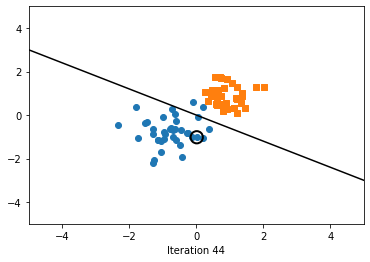

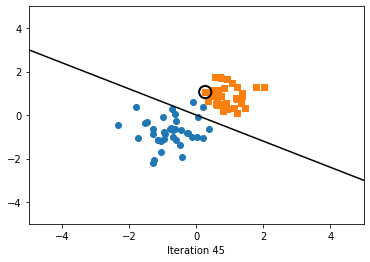

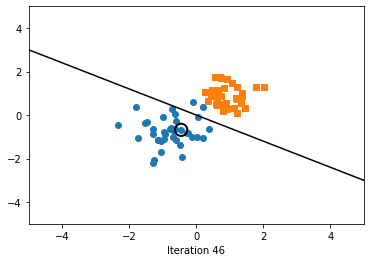

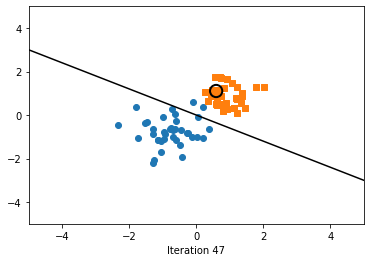

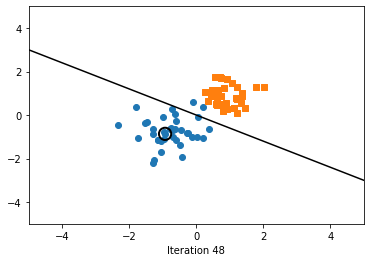

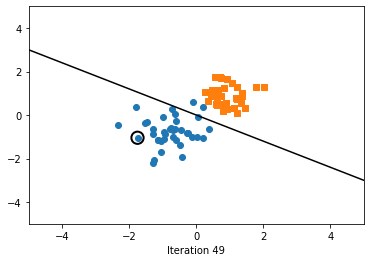

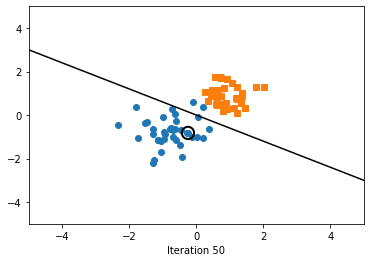

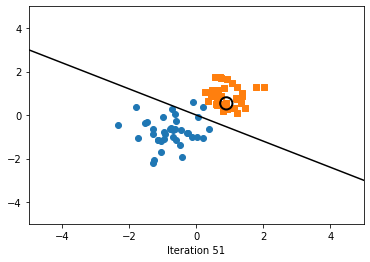

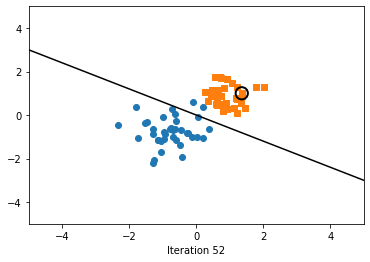

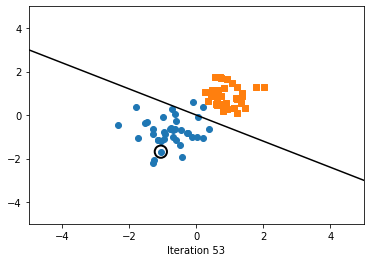

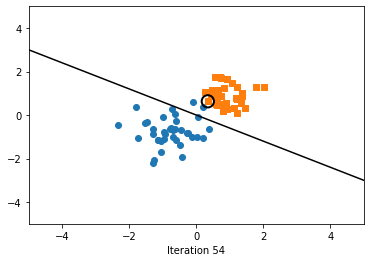

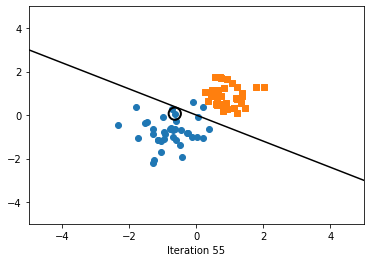

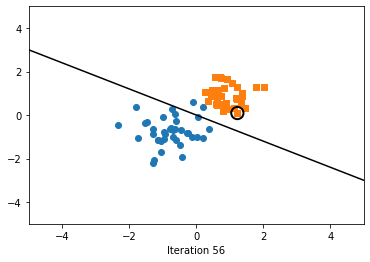

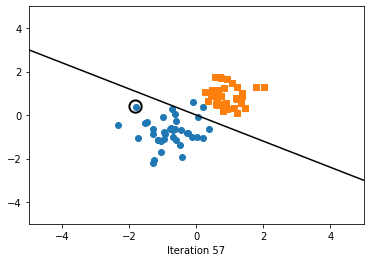

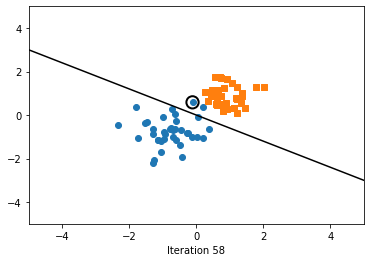

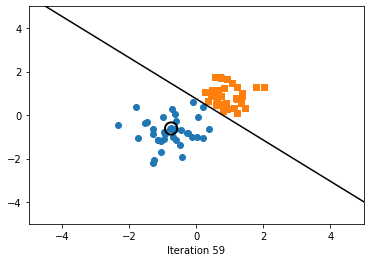

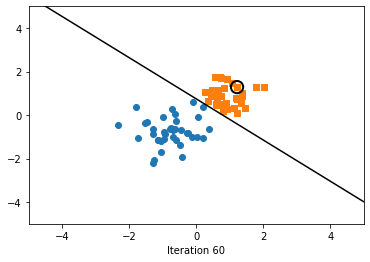

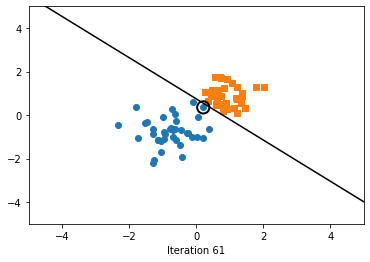

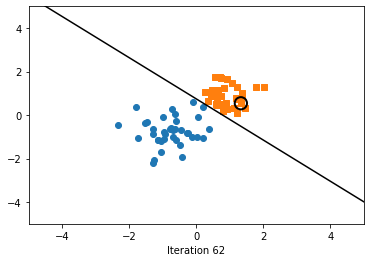

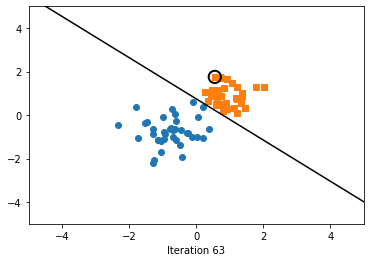

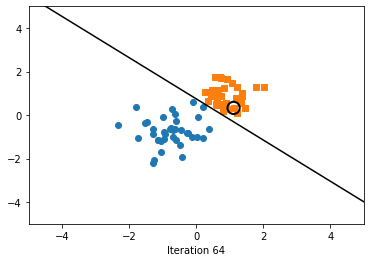

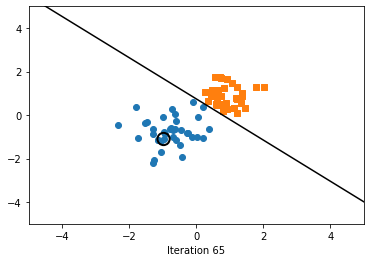

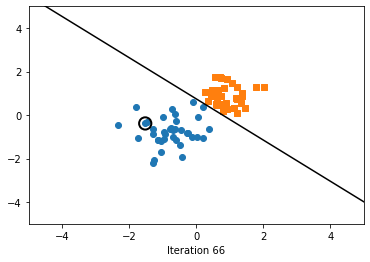

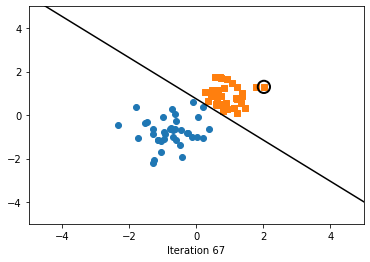

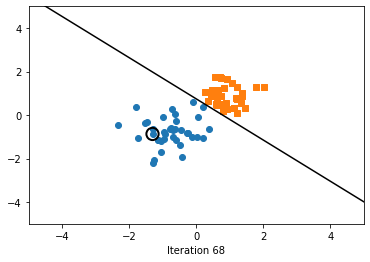

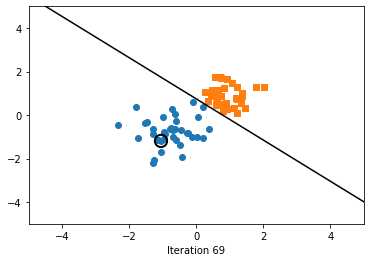

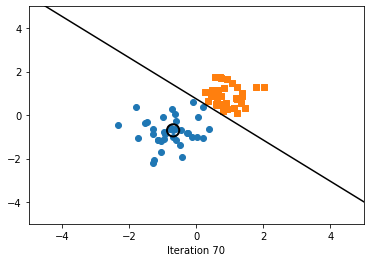

In [80]:
from ann import plot_learning_step
from functools import partial
plot_step = partial(plot_learning_step,
                    weights=all_weights, biases=all_biases,
                    X=X_train, y=y_train)

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('perceptron_training.gif', [plot_step(i) for i in
                                            range(len(all_weights))], fps=1);

In [81]:
acc

0.9333333333333333

---

# Single Layer Neural Network

<img src="../imgs/single_layer.png" width="65%" />

_(Source: Python Machine Learning, S. Raschka)_

### Weights Update Rule

- We use a **gradient descent** optimization algorithm to learn
the _Weights Coefficients_ of the model.
<br><br>
- In every **epoch** (pass over the training set), we update the weight vector
$w$ using the following update rule:

$$
w' = w + \Delta w, \text{ where } \Delta w = - \eta \nabla J(w)
$$

<br><br>

In other words, we computed the gradient based on the whole training set and updated
the weights of the model by taking a step into the **opposite direction**
of the gradient $ \nabla J(w)$.

In order to fin the **optimal weights of the model**, we optimized an objective
function (e.g. the Sum of Squared Errors (SSE)) cost function $J(w)$.

Furthermore, we multiply the gradient by a factor, the learning rate $\eta$ ,
which we choose carefully to balance the **speed of learning** against the risk of
overshooting the global minimum of the cost function.

### Gradient Descent

In **gradient descent optimization**, we update all the **weights simultaneously**
after each epoch, and we define the _partial derivative_ for each weight $w_j$
in the weight vector $w$ as follows:

$$
\frac{\partial}{\partial w_j} J(w) \propto \sum_{i} ( y^{(i)} - a^{(i)} )  x^{(i)}_j
$$

**Note**: _The superscript $(i)$ refers to the i-th sample.
The subscript $j$ refers to the j-th dimension/feature_


Here $y^{(i)}$ is the target class label of a particular sample $x^{(i)}$ ,
and $a^{(i)}$ is the **activation** of the neuron

(which is a linear function in the special case of _Perceptron_).

We define the **activation function** $\phi(\cdot)$ as follows:

$$
\phi(z) = z = a = \sum_{j} w_j x_j = \mathbf{w}^T \mathbf{x}
$$

In [83]:
### Updated version of Perceptron -> implemented learning rate
from ann import Perceptron

Perceptron??

Init signature: Perceptron(eta:float=0.01, epochs:int=10)
Source:        
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    epochs : int
        Steps over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """

    def __init__(self, eta: float = 0.01, epochs: int = 10):
        self.eta = eta
        self.n_epochs = epochs
        self.w_ = None
        self.errors_ = None

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : o

## Introducing the multi-layer neural network architecture

<img src="../imgs/multi-layers-1.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

Now we will see how to connect **multiple single neurons** to
a **multi-layer feedforward neural network**; this special type of network is
also called a **multi-layer perceptron** (MLP).

The figure shows the concept of an **MLP** consisting of three layers:
one _input_ layer, one _hidden_ layer, and one _output_ layer.

The units in the hidden layer are fully connected to the input layer,
and the output layer is fully connected to the hidden layer, respectively.

If such a network has **more than one hidden layer**,
we also call it a **deep artificial neural network**.


### Notation

we denote the `ith` activation unit in the `lth` layer as $a_i^{(l)}$ ,
and the activation units $a_0^{(1)}$ and
$a_0^{(2)}$ are the **bias units**, respectively, which we set equal to $1$. 
<br><br>
The _activation_ of the units in the **input layer** is just its input plus the bias unit:

$$
\mathbf{a}^{(1)} = [a_0^{(1)}, a_1^{(1)}, \ldots, a_m^{(1)}]^T = [1, x_1^{(i)}, \ldots, x_m^{(i)}]^T
$$
<br><br>
**Note**: $x_j^{(i)}$ refers to the jth feature/dimension of the ith sample

### Notes on Notation (usually) Adopted

The terminology around the indices (subscripts and superscripts)
may look a little bit confusing at first.
<br><br>

You may wonder why we wrote $w_{j,k}^{(l)}$ and not $w_{k,j}^{(l)}$ to refer to 
the **weight coefficient** that connects the *kth* unit in layer $l$ to the
jth unit in layer $l+1$.
<br><br>

What may seem a little bit quirky at first will make much more sense later
when we **vectorize** the neural network representation.
<br><br>

For example, we will summarize the weights that connect the input and
hidden layer by a matrix
$$ W^{(1)} \in \mathbb{R}^{h×[m+1]}$$

where $h$ is the number of hidden units and $m + 1$ is the number of
hidden units plus bias unit.

<img src="../imgs/multi-layers-2.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

## Forward Propagation

* Starting at the input layer, we forward propagate the patterns of the training
data through the network to generate an output.

* Based on the network's output, we calculate the error that we want to minimize
using a cost function that we will describe later.

* We backpropagate the error, find its derivative with respect to each weight
in the network, and update the model.

### Sigmoid Activation

<img src="../imgs/logistic_function.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

<img src="../imgs/fwd_step.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

<img src="../imgs/fwd_step_net.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

## Backward Propagation

The weights of each neuron are learned by **gradient descent**,
where each neuron's error is derived with respect to it's weight.

<img src="../imgs/bkwd_step_net.png" width="50%" />

_(Source: Python Machine Learning, S. Raschka)_

Optimization is done for each layer with respect to the previous layer
in a technique known as **BackPropagation**.

<img src="../imgs/backprop.png" width="50%">

(*The following code is inspired from [these](https://github.com/dennybritz/nn-from-scratch) terrific notebooks*)

In [29]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.2)

In [30]:
print(X.shape)
print(y.shape)

(500, 2)
(500,)


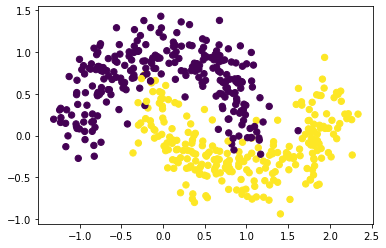

In [31]:
#Let's plot the dataset and see how it is
plt.scatter(X[:,0], X[:,1], s=40, c=y)
plt.show()

## Start Building our MLP building blocks

Note: This process will eventually result in our own Neural Networks class

### A look at the details

<img src="../imgs/mlp_details.png" width="65%" />

In [32]:
import random
random.seed(123)

# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

##### Function to generate a random number, given two numbers

**Where will it be used?**: When we initialize the neural networks, the weights have to be randomly assigned.

In [33]:
# Make a matrix 
def makeMatrix(I, J, fill=0.0):
    return np.zeros([I,J])

### Define our activation function. Let's use sigmoid function

In [34]:
# our sigmoid function
def sigmoid(x):
    #return math.tanh(x)
    return 1/(1+np.exp(-x))

### Derivative of our activation function. 

Note: We need this when we run the backpropagation algorithm


In [35]:
# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return y - y**2

### Our neural networks class

When we first create a neural networks architecture, we need to know the number of inputs, number of hidden layers and number of outputs.

The weights have to be randomly initialized.

```python
class MLP:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        self.wi = rand(-0.2, 0.2, size=self.wi.shape)
        self.wo = rand(-2.0, 2.0, size=self.wo.shape)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
```

### Activation Function

```python
def activate(self, inputs):
        
    if len(inputs) != self.ni-1:
        print(inputs)
        raise ValueError('wrong number of inputs')

    # input activations
    for i in range(self.ni-1):
        self.ai[i] = inputs[i]

    # hidden activations
    for j in range(self.nh):
        sum_h = 0.0
        for i in range(self.ni):
            sum_h += self.ai[i] * self.wi[i][j]
        self.ah[j] = sigmoid(sum_h)

    # output activations
    for k in range(self.no):
        sum_o = 0.0
        for j in range(self.nh):
            sum_o += self.ah[j] * self.wo[j][k]
        self.ao[k] = sigmoid(sum_o)

    return self.ao[:]
```

### BackPropagation

```python
def backPropagate(self, targets, N, M):
        
    if len(targets) != self.no:
        print(targets)
        raise ValueError('wrong number of target values')

    # calculate error terms for output
    output_deltas = np.zeros(self.no)
    for k in range(self.no):
        error = targets[k]-self.ao[k]
        output_deltas[k] = dsigmoid(self.ao[k]) * error

    # calculate error terms for hidden
    hidden_deltas = np.zeros(self.nh)
    for j in range(self.nh):
        error = 0.0
        for k in range(self.no):
            error += output_deltas[k]*self.wo[j][k]
        hidden_deltas[j] = dsigmoid(self.ah[j]) * error

    # update output weights
    for j in range(self.nh):
        for k in range(self.no):
            change = output_deltas[k] * self.ah[j]
            self.wo[j][k] += N*change + 
                             M*self.co[j][k]
            self.co[j][k] = change

    # update input weights
    for i in range(self.ni):
        for j in range(self.nh):
            change = hidden_deltas[j]*self.ai[i]
            self.wi[i][j] += N*change + 
                             M*self.ci[i][j]
            self.ci[i][j] = change

    # calculate error
    error = 0.0
    for k in range(len(targets)):
        error += 0.5*(targets[k]-self.ao[k])**2
    return error
```

In [36]:
# Putting all together

from ann import MLP

### Running the model on our dataset

In [37]:
# create a network with two inputs, one hidden, and one output nodes
mlp = MLP(2, 1, 1)

%timeit -n 1 -r 1 mlp.train(zip(X,y), iterations=2)

28.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Predicting on training dataset and measuring in-sample accuracy

In [38]:
%timeit -n 1 -r 1 mlp.test(X)

11.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
print(np.asarray(y[:30], dtype=np.float))
print(np.ravel(mlp.predict)[:30])

[0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0.]
[0.12816345 0.4654988  0.49779427 0.4923827  0.49480715 0.48815746
 0.37162079 0.12494447 0.46541859 0.49440472 0.13638834 0.28255646
 0.11657211 0.44200891 0.47966601 0.13387515 0.49496247 0.49460237
 0.49851176 0.49513558 0.48740148 0.42216443 0.38335372 0.3181002
 0.49366907 0.15896832 0.12574849 0.47175315 0.3034798  0.09975951]


### Let's visualize and observe the results

In [40]:
# Helper function to plot a decision boundary.
# This generates the contour plot to show the decision boundary visually
def plot_decision_boundary(nn_model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    nn_model.test(np.c_[xx.ravel(), yy.ravel()])
    Z = nn_model.predict
    Z[Z>=0.5] = 1
    Z[Z<0.5] = 0
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=40,  c=y, cmap=plt.cm.BuGn)

Text(0.5, 1.0, 'Our initial model')

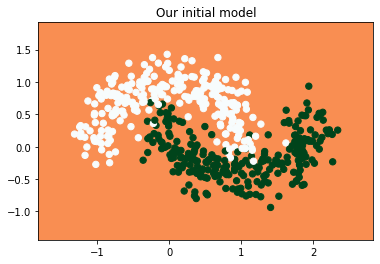

In [41]:
plot_decision_boundary(mlp)
plt.title("Our initial model")

**Exercise**: 

Create Neural networks with 10 hidden nodes on the above code. 

What's the impact on accuracy?

171 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Text(0.5, 1.0, 'Our next model with 10 hidden units')

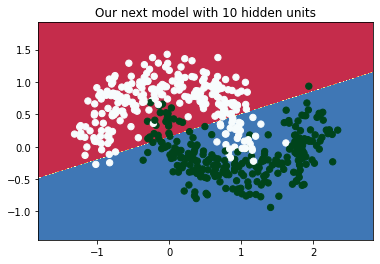

In [42]:
mlp = MLP(2, 10, 1)
%timeit -n 1 -r 1 mlp.train(zip(X,y), iterations=2)
plot_decision_boundary(mlp)
plt.title("Our next model with 10 hidden units")

**Exercise:**

Train the neural networks by increasing the epochs. 

What's the impact on accuracy?

Text(0.5, 1.0, 'Our next model with 10 hidden units')

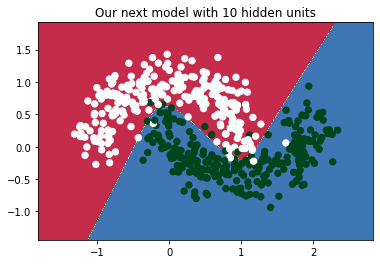

In [43]:
mlp = MLP(2, 10, 1)
mlp.train(zip(X,y), iterations=100)
# %timeit -n 1 -r 1 mlp.train(zip(X,y), iterations=100)
plot_decision_boundary(mlp)
plt.title("Our next model with 10 hidden units")

# Addendum

Another terrific reference to start is the online book http://neuralnetworksanddeeplearning.com/. Highly recommended!  